Epoch 1/100
60/60 [==============================] - 9s 36ms/step - loss: 0.4061 - accuracy: 0.8849 - val_loss: 0.3415 - val_accuracy: 0.8954
Epoch 2/100
60/60 [==============================] - 2s 25ms/step - loss: 0.3531 - accuracy: 0.9006 - val_loss: 0.3255 - val_accuracy: 0.8954
Epoch 3/100
60/60 [==============================] - 2s 26ms/step - loss: 0.3381 - accuracy: 0.9006 - val_loss: 0.3269 - val_accuracy: 0.8954
Epoch 4/100
60/60 [==============================] - 2s 28ms/step - loss: 0.3384 - accuracy: 0.9006 - val_loss: 0.3285 - val_accuracy: 0.8954
Epoch 5/100
60/60 [==============================] - 2s 30ms/step - loss: 0.3408 - accuracy: 0.9006 - val_loss: 0.3302 - val_accuracy: 0.8954
Epoch 6/100
60/60 [==============================] - 1s 24ms/step - loss: 0.3295 - accuracy: 0.9006 - val_loss: 0.3297 - val_accuracy: 0.8954
Epoch 7/100
60/60 [==============================] - 2s 25ms/step - loss: 0.3298 - accuracy: 0.9006 - val_loss: 0.3286 - val_accuracy: 0.8954
Epoch 

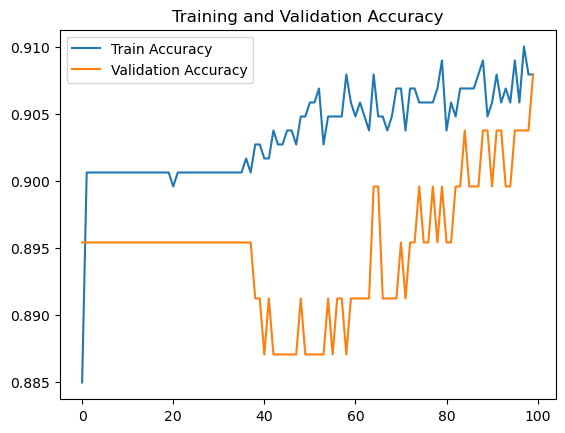

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Load the data
building_file_path = "aoi_air_temperature_data.csv"  # Replace with your building count file path
temperature_file_path = "large_aoi_building_counts.csv"  # Replace with your temperature file path

# Load building count data
building_data = pd.read_csv(building_file_path)
# Load air temperature data
temperature_data = pd.read_csv(temperature_file_path)

# Step 2: Extract and align data
# Assuming AOI is the first column and years start from column 2 onwards
aoi_list = building_data.iloc[:, 0].values  # Extract AOIs
building_values = building_data.iloc[:, 1:].values  # Yearly building count
temperature_values = temperature_data.iloc[:, 1:].values  # Yearly temperature data

# Calculate yearly temperature changes (difference)
temperature_changes = np.diff(temperature_values, axis=1)  # Yearly differences
# Align building values to match temperature change shape
building_values_aligned = building_values[:, :-1]  # Exclude last year to match dimensions

# Combine building count and temperature change data
combined_data = np.hstack([building_values_aligned, temperature_changes])

# Normalize the combined dataset
scaler = MinMaxScaler()
combined_data_normalized = scaler.fit_transform(combined_data)

# Step 3: Create risk labels (1 for high-risk, 0 for low-risk)
# Define high-risk AOIs as those with the highest temperature changes
risk_labels = np.max(temperature_changes, axis=1)  # Max temperature change for each AOI
risk_threshold = np.percentile(risk_labels, 90)  # Top 10% as high-risk
risk_labels = (risk_labels >= risk_threshold).astype(int)  # 1 for high-risk, 0 for low-risk

# Step 4: Prepare sequences for LSTM
def create_sequences(data, labels, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(labels[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(combined_data_normalized, risk_labels, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Build the LSTM classification model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(time_steps, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Step 6: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Step 7: Make predictions
predictions = model.predict(X_test)
predicted_labels = (predictions >= 0.5).astype(int)

# Map high-risk predictions to AOIs
high_risk_aoi_indices = np.where(predicted_labels == 1)[0]
high_risk_aois = [aoi_list[i] for i in high_risk_aoi_indices]
print("Predicted High-Risk AOIs:", high_risk_aois)

# Optional: Plot the training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


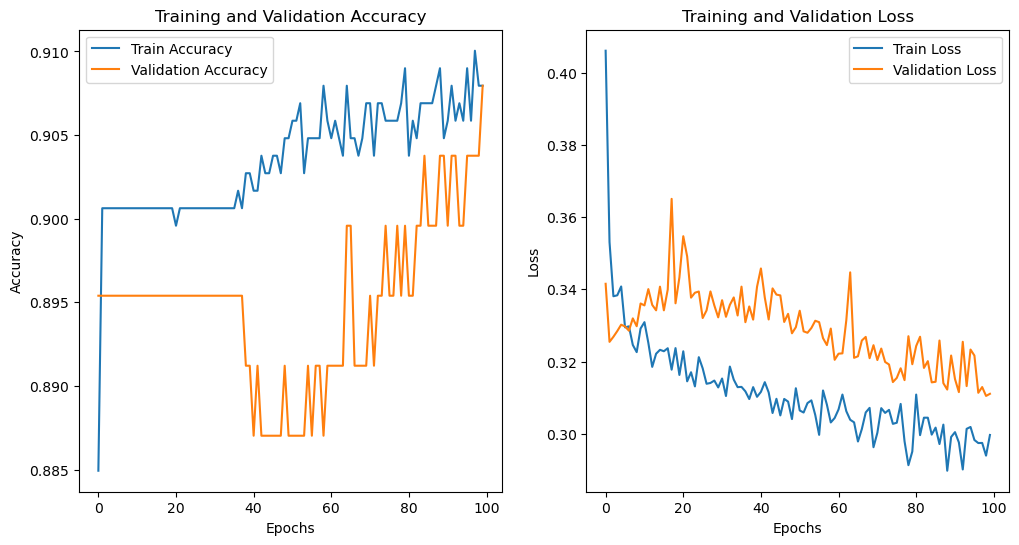

In [34]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


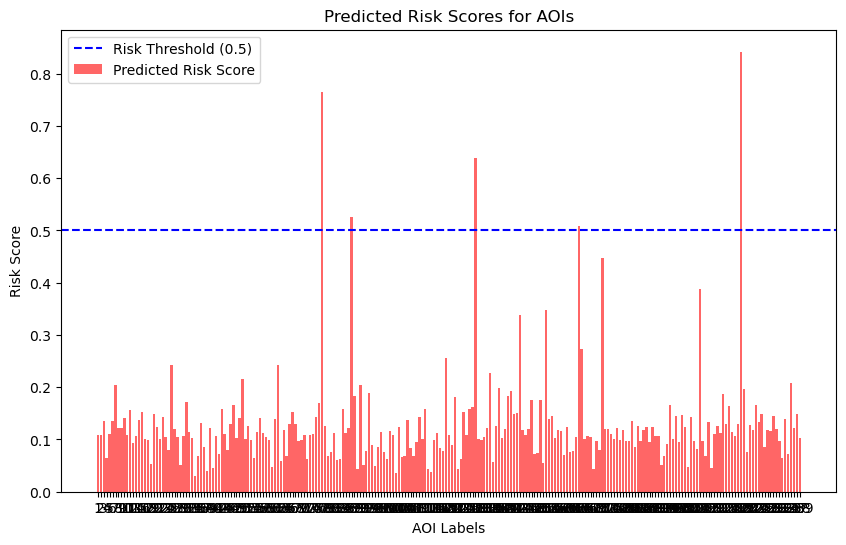

In [38]:
# Use numeric labels for AOIs
aoi_labels = range(1, len(y_test) + 1)  # Create numeric labels (1, 2, 3, ...)

# Predicted risk scores
predicted_risk_scores = predictions.flatten()  # Predicted risk probabilities

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(aoi_labels, predicted_risk_scores, color='r', alpha=0.6, label='Predicted Risk Score')
plt.axhline(y=0.5, color='b', linestyle='--', label='Risk Threshold (0.5)')
plt.title("Predicted Risk Scores for AOIs")
plt.xlabel("AOI Labels")
plt.ylabel("Risk Score")
plt.xticks(aoi_labels)  # Use numeric labels
plt.legend()
plt.show()

